[View in Colaboratory](https://colab.research.google.com/github/mahsayedsalem/StackOverViewTagsPredictions/blob/master/MultilabelClassification.ipynb)

# Predict tags on StackOverflow with linear models

In [0]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
from ast import literal_eval
import pandas as pd
import numpy as np

In [0]:
def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data

In [0]:
train = read_data('data/train.tsv')
validation = read_data('data/validation.tsv')
test = pd.read_csv('data/test.tsv', sep='\t')

In [0]:
train.head()

,title,tags
0,How to draw a stacked dotplot in R?,[r]
1,mysql select all records where a datetime fiel...,"[php, mysql]"
2,How to terminate windows phone 8.1 app,[c#]
3,get current time in a specific country via jquery,"[javascript, jquery]"
4,Configuring Tomcat to Use SSL,[java]


In [0]:
len(train)

100000

In [0]:
X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values
X_test = test['title'].values

In [0]:
import re

In [0]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    
    text = text.lower()
    text = re.sub(REPLACE_BY_SPACE_RE, " ", text) 
    text = re.sub(BAD_SYMBOLS_RE, "", text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
   
    return text

In [0]:
def test_text_prepare():
    examples = ["SQL Server - any equivalent of Excel's CHOOSE function?",
                "How to free c++ memory vector<int> * arr?"]
    answers = ["sql server equivalent excels choose function", 
               "free c++ memory vectorint arr"]
    for ex, ans in zip(examples, answers):
        if text_prepare(ex) != ans:
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [0]:
print(test_text_prepare())

Basic tests are passed.


In [0]:
prepared_questions = []
for line in open('data/text_prepare_tests.tsv', encoding='utf-8'):
    line = text_prepare(line.strip())
    prepared_questions.append(line)
text_prepare_results = '\n'.join(prepared_questions)

grader.submit_tag('TextPrepare', text_prepare_results)

Current answer for task TextPrepare is:
 sqlite php readonly
creating multiple textboxes dynamically
self one prefer javascript
save php date...


In [0]:
X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]

In [0]:
X_train[:3]

['draw stacked dotplot r',
 'mysql select records datetime field less specified value',
 'terminate windows phone 81 app']

In [0]:
tags_counts = {}
words_counts = {}

from collections import Counter
tags_counts = Counter([item for taglist in y_train for item in taglist])
words_counts = Counter([word for line in X_train for word in line.split(' ')])

In [0]:
most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:3]
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:3]

grader.submit_tag('WordsTagsCount', '%s\n%s' % (','.join(tag for tag, _ in most_common_tags), 
                                                ','.join(word for word, _ in most_common_words)))

Current answer for task WordsTagsCount is:
 javascript,c#,java
using,php,java...


In [0]:
DICT_SIZE = 5000

VOCAB = words_counts.most_common(DICT_SIZE)
WORDS_TO_INDEX = {item[0]:ii for ii, item in enumerate(sorted(VOCAB, key=lambda x: x[1], reverse=True))} ####### YOUR CODE HERE #######
INDEX_TO_WORDS = {ii:word for word, ii in WORDS_TO_INDEX.items()} ####### YOUR CODE HERE #######
ALL_WORDS = WORDS_TO_INDEX.keys()

def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(dict_size)
    
    for word in text.split(' '):
        if word in words_to_index:
            result_vector[words_to_index[word]] +=1
    return result_vector

In [0]:
def test_my_bag_of_words():
    words_to_index = {'hi': 0, 'you': 1, 'me': 2, 'are': 3}
    examples = ['hi how are you']
    answers = [[1, 1, 0, 1]]
    for ex, ans in zip(examples, answers):
        if (my_bag_of_words(ex, words_to_index, 4) != ans).any():
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [0]:
print(test_my_bag_of_words())

Basic tests are passed.


In [0]:
from scipy import sparse as sp_sparse

In [0]:
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
print('X_train shape ', X_train_mybag.shape)
print('X_val shape ', X_val_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (100000, 5000)
X_val shape  (30000, 5000)
X_test shape  (20000, 5000)


In [0]:
row = X_train_mybag[10].toarray()[0]
non_zero_elements_count = np.count_nonzero(row) 

grader.submit_tag('BagOfWords', str(non_zero_elements_count))

Current answer for task BagOfWords is:
 7...


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
def tfidf_features(X_train, X_val, X_test):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test, and val sets and return the result
    
    
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=5, token_pattern='(\S+)') ####### YOUR CODE HERE #######
    
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_val_tfidf = tfidf_vectorizer.transform(X_val)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    
    return X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vectorizer.vocabulary_

In [0]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [0]:
print('python' in tfidf_vocab)
print('c++' in tfidf_vocab)
print('php' in tfidf_vocab)

True
True
True


In [0]:
tfidf_reversed_vocab[10]

'+ ajax'

In [0]:
from sklearn.preprocessing import MultiLabelBinarizer

In [0]:
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train = mlb.fit_transform(y_train)
y_val = mlb.fit_transform(y_val)

In [0]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [0]:
def train_classifier(X_train, y_train):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """
    
    # Create and fit LogisticRegression wraped into OneVsRestClassifier.

    clf = OneVsRestClassifier(RidgeClassifier(normalize=True))
    clf.fit(X_train, y_train)
    return clf  

In [0]:
classifier_mybag = train_classifier(X_train_mybag, y_train)
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

In [0]:
y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

In [0]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val_inversed = mlb.inverse_transform(y_val)
for i in range(3):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

Title:	odbc_exec always fail
True labels:	php,sql
Predicted labels:	


Title:	access base classes variable within child class
True labels:	javascript
Predicted labels:	class


Title:	contenttype application json required rails
True labels:	ruby,ruby-on-rails
Predicted labels:	json,ruby,ruby-on-rails,ruby-on-rails-3




In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

In [0]:
def print_evaluation_scores(y_val, predicted):
    
    print(accuracy_score(y_val, predicted))
    print(f1_score(y_val, predicted, average='weighted'))
    print(average_precision_score(y_val, predicted))

In [0]:
print('Bag-of-words')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Bag-of-words
0.025033333333333335
0.49154754204901024
0.18724902379965525
Tfidf
0.23696666666666666
0.6619918621874316
0.368708886846398


In [0]:
from metrics import roc_auc
%matplotlib inline

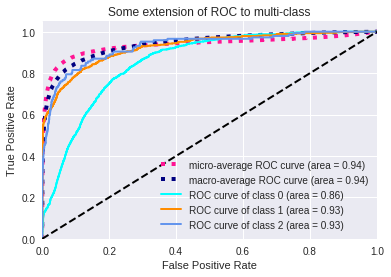

In [0]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_mybag, n_classes)

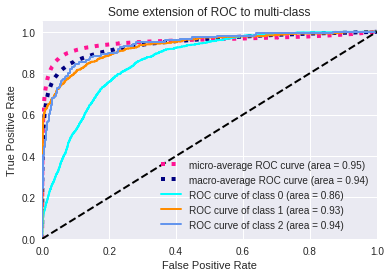

In [0]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_tfidf, n_classes)

In [0]:
test_predictions = classifier_tfidf.predict(X_test_tfidf)
test_pred_inversed = mlb.inverse_transform(test_predictions)

test_predictions_for_submission = '\n'.join('%i\t%s' % (i, ','.join(row)) for i, row in enumerate(test_pred_inversed))
grader.submit_tag('MultilabelClassification', test_predictions_for_submission)

Current answer for task MultilabelClassification is:
 0	mysql,php
1	html,javascript,jquery
2	
3	javascript,jquery
4	android,java
5	parsing,php,xml
6	c#,js...


In [0]:
def print_words_for_tag(classifier, tag, tags_classes, index_to_words, all_words):
    
    print('Tag:\t{}'.format(tag))
    
    
    estimator = classifier.estimators_[tags_classes.index(tag)]
    coff = estimator.coef_[0]
    coff_idx = list(enumerate(coff))
    top_pos_words_idx = [idx for idx, wt in sorted(coff_idx, key=lambda x: x[1], reverse=True)[:5]]
    top_neg_words_idx = [idx for idx, wt in sorted(coff_idx, key=lambda x: x[1], reverse=False)[:5]]
    top_positive_words = [index_to_words[idx] for idx in top_pos_words_idx] # top-5 words sorted by the coefficiens.
    top_negative_words = [index_to_words[idx] for idx in top_neg_words_idx] # bottom-5 words  sorted by the coefficients.
    print('Top positive words:\t{}'.format(', '.join(top_positive_words)))
    print('Top negative words:\t{}\n'.format(', '.join(top_negative_words)))

In [0]:
print_words_for_tag(classifier_tfidf, 'c', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'c++', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'linux', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)

Tag:	c
Top positive words:	c, c c++, malloc, scanf, pointer
Top negative words:	objective c, objective, java, python, php

Tag:	c++
Top positive words:	c++, qt, opencv, boost, mfc
Top negative words:	java, python, c#, php, javascript

Tag:	linux
Top positive words:	linux, linux c, kernel space, linux using, ubuntu
Top negative words:	run bash, c#, c unix, javascript, parent process

